The [new editor retention rate](https://meta.wikimedia.org/wiki/Research:Surviving_new_editor) suddenly spiked among the January 2018 cohort of new editors. Is this real or is it a bug in the data?

In [1]:
glob_ret = pd.read_table("data/adl_global_monthly_retention.tsv")
glob_ret.head()

,cohort,new_eds,ret
0,2014-04,110977,0.053768
1,2014-05,123509,0.047381
2,2014-06,104241,0.052820
3,2014-07,111230,0.054724
4,2014-08,114329,0.053678


In [2]:
proj_ret = pd.read_table("data/adl_project_monthly_retention.tsv")
proj_ret.head()

,wiki,cohort,new_eds,retention
0,abwiki,2017-06,1,0.0
1,abwiki,2017-11,2,0.0
2,acewiki,2017-06,2,1.0
3,acewiki,2017-07,1,0.0
4,adywiki,2017-09,9,0.0


In [3]:
# Filter out small wikis likely to have too much noise
proj_ret = proj_ret.query("new_eds >= 100")
proj_ret.head()

,wiki,cohort,new_eds,retention
62,arwiki,2017-01,2495,0.048096
63,arwiki,2017-02,2536,0.048107
64,arwiki,2017-03,2832,0.049082
65,arwiki,2017-04,2833,0.033533
66,arwiki,2017-05,2375,0.032421


In [13]:
def global_retention(df):
    return (df["new_eds"] * df["retention"]).sum() / df["new_eds"].sum()

avg_proj_ret = proj_ret.query("cohort != '2018-01'").groupby("wiki").apply(global_retention)
avg_proj_ret = pd.DataFrame(avg_proj_ret, columns = ["avg_ret"])

avg_proj_ret.head()

,avg_ret
wiki,
arwiki,0.038981
azwiki,0.099445
bgwiki,0.037083
bnwiki,0.041036
cawiki,0.090738


In [20]:
jan_proj_ret = proj_ret.query("cohort == '2018-01'").set_index("wiki")["retention"]
jan_proj_ret = pd.DataFrame(jan_proj_ret).rename(columns = {"retention": "jan_ret"})
jan_proj_ret.head()

,jan_ret
wiki,
arwiki,0.040326
azwiki,0.105769
bgwiki,0.038251
bnwiki,0.052448
cawiki,0.033582


In [26]:
proj_ret_vs = avg_proj_ret.join(jan_proj_ret, how = "inner")
proj_ret_vs.head()

,avg_ret,jan_ret
wiki,,
arwiki,0.038981,0.040326
azwiki,0.099445,0.105769
bgwiki,0.037083,0.038251
bnwiki,0.041036,0.052448
cawiki,0.090738,0.033582


In [40]:
s = pd.DataFrame(proj_ret_vs.stack(), columns = ["retention"])
s.head()

retention
wiki                     
arwiki avg_ret   0.038981
       jan_ret   0.040326
azwiki avg_ret   0.099445
       jan_ret   0.105769
bgwiki avg_ret   0.037083

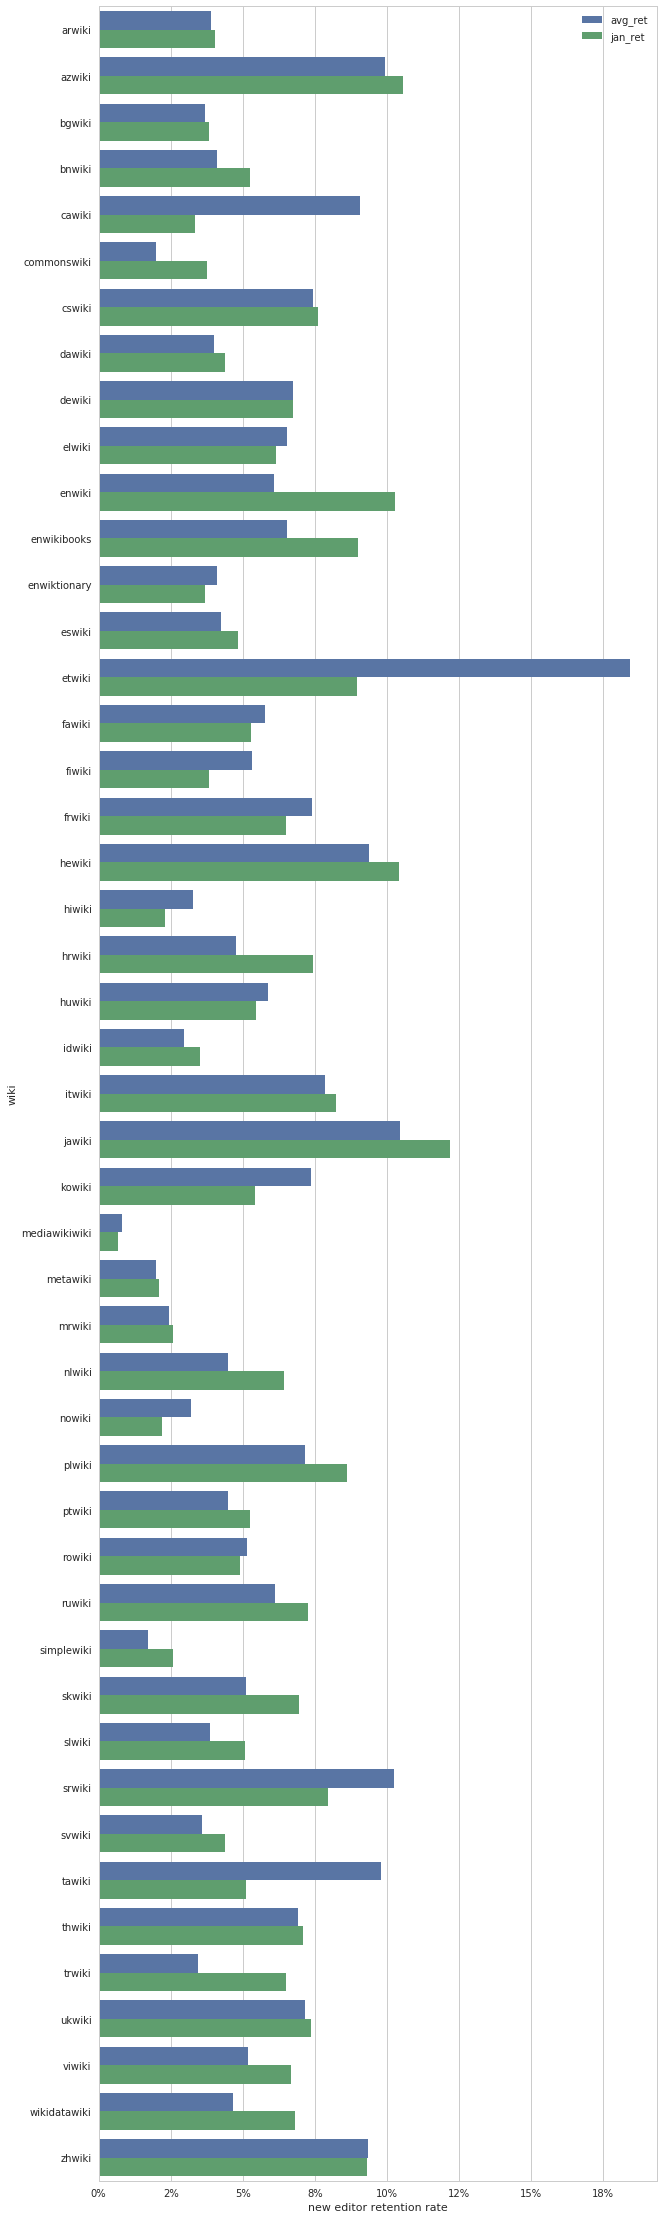

In [72]:
import seaborn as sns
import matplotlib as mpl

fig, ax = plt.subplots(figsize = (10, 40))

fmt = mpl.ticker.FuncFormatter(lambda x, pos: "{:.0%}".format(x))

ax.xaxis.set_major_formatter(fmt)

g = sns.barplot(x = s.retention, y = s.index.get_level_values(0), hue = s.index.get_level_values(1))

ax.xaxis.set_label_text("new editor retention rate")

In [76]:
# Ten highest retention wikis on average
avg_proj_ret.sort_values("avg_ret", ascending = False).head(n = 10)

,avg_ret
wiki,
euwiki,0.362776
etwiki,0.184361
hywiki,0.165217
enwikiversity,0.162313
knwiki,0.106195
jawiki,0.104687
srwiki,0.102374
azwiki,0.099445
tawiki,0.098119


In [77]:
# Ten highest retention wikis in January
jan_proj_ret.sort_values("jan_ret", ascending = False).head(n = 10)

,jan_ret
wiki,
jawiki,0.121892
azwiki,0.105769
hewiki,0.104242
enwiki,0.102744
zhwiki,0.093240
enwikibooks,0.090090
etwiki,0.089744
plwiki,0.086285
itwiki,0.082331


In [88]:
def pct(num):
    print("{:.2%}".format(num))

# Average without enwiki
pct(global_retention(proj_ret.query("wiki != 'enwiki' and cohort != '2018-01'")))

5.72%


In [89]:
# January without enwiki
pct(global_retention(proj_ret.query("wiki != 'enwiki' and cohort == '2018-01'")))

6.36%


In [91]:
enw_new = pd.read_csv("data/adl_enwiki_new_editors.tsv")
enw_new.head()

,user_name,cohort,1st_month_edits,2nd_month_edits
0,!0Clarke,2018-01-06,3,0
1,!0MinutesADay,2017-11-17,1,0
2,!7everton,2017-11-20,2,0
3,!Cookiesarenice!,2017-12-05,4,0
4,!Ideas,2018-01-16,1,0


In [104]:
def ret(g):
    df = enw_new
    
    new_eds =  g["user_name"].count()
    ret_eds = g[df.ix[g.index]["2nd_month_edits"] >= 1]["user_name"].count()
    return ret_eds / new_eds

adl_new = enw_new.groupby("cohort").count()["user_name"]

adl_ret = enw_new.groupby("cohort").apply(ret)

pd.DataFrame({"new": adl_new, "ret": adl_ret})

,new,ret
cohort,,
2017-11-01,1701,0.094062
2017-11-02,1690,0.059763
2017-11-03,1539,0.055231
2017-11-04,1285,0.053696
2017-11-05,1411,0.051028
2017-11-06,1942,0.088054
2017-11-07,1948,0.063655
2017-11-08,1914,0.063218
2017-11-09,1735,0.051297


In [ ]:
adl_ret

## MariaDB

In [ ]:
en_new_revs = pd.read_table("data/mdb_enwiki_new_user_revisions.tsv")

In [ ]:
en_new_revs.sample(n = 10)

In [ ]:
import datetime as dt

rich_revs = en_new_revs.copy()
td_30 = dt.timedelta(days = 30)
td_60 = dt.timedelta(days = 60)

rich_revs["since_reg"] = rich_revs["edit_t"] -  rich_revs["reg_t"]
rich_revs["first_mo"] = rich_revs["since_reg"] < td_30
rich_revs["second_mo"] = (rich_revs["since_reg"] >= td_30) & (rich_revs["since_reg"] < td_60)

In [ ]:
rich_revs.sample(n = 10)

In [ ]:
en_new_users = rich_revs.groupby("user_id").agg({
    "reg_t": lambda x: dt.datetime.date(np.min(x)),
    "first_mo": np.sum,
    "second_mo": np.sum
})

In [ ]:
en_new_users.sample(n = 10)

In [ ]:
editors = lambda x: (x >= 1).sum()

cohorts = en_new_users.groupby("reg_t").agg({
    "first_mo": editors,
    "second_mo": editors
})

cohorts.head()

In [ ]:
cohorts["retention"] = cohorts["second_mo"] / cohorts["first_mo"]

cohorts = cohorts.reindex(cohorts.index.rename("cohort"))

cohorts.head()

In [ ]:
jan_31 = dt.date(2018, 1, 31)
mdb_ret = cohorts[:jan_31]["retention"]

In [ ]:

pd.merge(pd.DataFrame(adl_ret), pd.DataFrame(mdb_ret), left_index = True, right_index = True)

In [ ]:
pd.DataFrame(adl_ret).join(pd.DataFrame(mdb_ret))

In [ ]:
pd.DataFrame(adl_ret).index